In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/17G0FfNU4I37VaDXUPFsaOhyxDYULipag/Dataset


# ***General***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from imblearn.metrics import sensitivity_specificity_support
import seaborn as sn
import pandas as pd
from sklearn import metrics

In [4]:
path, dirs, files = next(os.walk("train/all"))
file_count = len(files)
print("Apnormal : ",file_count)
path, dirs, files = next(os.walk("train/hem"))
file_count = len(files)
print("Normal : ",file_count)

Apnormal :  5965
Normal :  5171


In [5]:
def Read_Dataset(image_size, batch_size):

  train_df = tf.keras.preprocessing.image_dataset_from_directory(
      "train",
      image_size = image_size,
      batch_size = batch_size,
  )

  val_df = tf.keras.preprocessing.image_dataset_from_directory(
      "val",
      image_size = image_size,
      batch_size = batch_size,
  )

  test_df = tf.keras.preprocessing.image_dataset_from_directory(
      "test",
      image_size = image_size,
      batch_size = batch_size,
      shuffle = False,
  )

  train_df = train_df.prefetch(buffer_size = 32)

  val_df = val_df.prefetch(buffer_size = 32)

  y_test = np.concatenate([y for x, y in test_df], axis = 0)

  return train_df, val_df, test_df, y_test

In [6]:
def get_callbacks(model_name):
  callbacks = []

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f'model.{model_name}.h5', verbos = 1, monitor = 'val_loss', mode = "min", save_best_only = True, save_freq = "epoch")
  callbacks.append(checkpoint)
  anne = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 2, min_lr = 0.0000001, min_delta = 0.00001, mode = "auto")
  callbacks.append(anne)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  callbacks.append(earlystop)

  return callbacks

In [7]:
def Create_Model(model_name, IMG_SHAPE):
  OPTIMIZER = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

  if model_name == "MobileNet":
    base_model = tf.keras.applications.MobileNet(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "Xception":
    base_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "InceptionV3":
     base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB2":
    base_model = tf.keras.applications.EfficientNetB2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "NASNetMobile":
    base_model = tf.keras.applications.NASNetMobile(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB4":
    base_model = tf.keras.applications.EfficientNetB4(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")

  base_model.trainable = True
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
  model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

  model.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(.5)])

  return model

In [8]:
def Train_Validation(epoches, acc, val_acc, loss, val_loss):
  plt.plot(epoches, acc, label = 'Training accuarcy')
  plt.plot(epoches, val_acc, label = 'Validation accuarcy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epoches, loss, label = 'Training loss')
  plt.plot(epoches, val_loss, label = 'Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [9]:
def predict(test_df, y_test):
  y_pred = model.predict(test_df, verbose = 1).round()
  y_pred = y_pred.flatten()
  
  target_names = ['Class Normal', 'Class ApNormal']
  return classification_report(y_test, y_pred, target_names = target_names, digits = 4), y_pred

In [10]:
def Confusion(y_test, y_pred, model_name):
  disp = metrics.confusion_matrix(y_test, y_pred)
  disp.astype('int')
  pd.options.display.float_format = '{:.5f}'.format
  target_names = ['Normal', 'ApNormal']
  df_cm = pd.DataFrame(disp, target_names, target_names)
  fig, ax = plt.subplots(figsize = (4,4))
  sn.set(font_scale = 1.5)
  sn.heatmap(df_cm, annot = True, annot_kws = {"size": 15}, ax = ax, cmap = "YlOrBr", fmt = 'g', cbar = False)
  plt.xlabel('Actual', fontsize = 20)
  plt.ylabel('Predicted', fontsize = 20)
  plt.ioff()
  plt.savefig(f"confusion_mat_{model_name}", bbox_inches = 'tight')
  plt.show()

#Inception Model

In [11]:
model_name = "inceptionV3"
train_df, val_df, test_df, y_test = Read_Dataset((299,299),32)

Found 11136 files belonging to 2 classes.
Found 3175 files belonging to 2 classes.
Found 1590 files belonging to 2 classes.


In [12]:
model = Create_Model("InceptionV3",(299,299,3))
print(model.summary())

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [13]:
callbacks = get_callbacks("inceptionV3")
history = model.fit(train_df, epochs = 50, validation_data = val_df, callbacks = [callbacks])

Epoch 1/50
348/348 [==============================] - 3291s 9s/step - loss: 0.3112 - accuracy: 0.8697 - precision: 0.9022 - recall: 0.8068 - specificity_at_sensitivity: 0.9985 - sensitivity_at_specificity: 0.9561 - val_loss: 4.0001 - val_accuracy: 0.4759 - val_precision: 0.4702 - val_recall: 1.0000 - val_specificity_at_sensitivity: 0.3104 - val_sensitivity_at_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/50
348/348 [==============================] - 175s 497ms/step - loss: 0.2323 - accuracy: 0.9059 - precision: 0.9310 - recall: 0.8611 - specificity_at_sensitivity: 0.9993 - sensitivity_at_specificity: 0.9812 - val_loss: 46.9714 - val_accuracy: 0.4652 - val_precision: 0.4652 - val_recall: 1.0000 - val_specificity_at_sensitivity: 0.0000e+00 - val_sensitivity_at_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/50
348/348 [==============================] - 176s 502ms/step - loss: 0.2056 - accuracy: 0.9175 - precision: 0.9385 - recall: 0.8799 - specificity_at_sensitivity: 0.9993 - sensitivity_at_

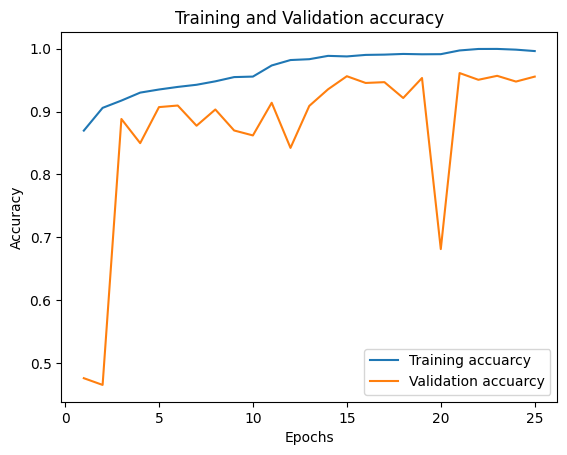

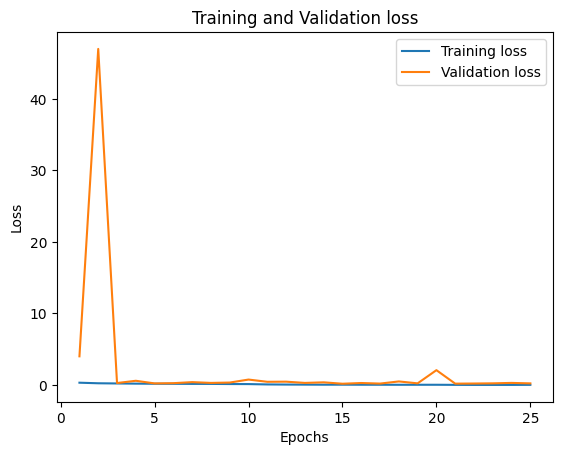

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoches = range(1, len(acc) + 1)
Train_Validation(epoches, acc, val_acc, loss, val_loss)

In [15]:
results = model.evaluate(test_df, verbose = 1)

50/50 [==============================] - 13s 262ms/step - loss: 0.2936 - accuracy: 0.9503 - precision: 0.9521 - recall: 0.9405 - specificity_at_sensitivity: 0.9882 - sensitivity_at_specificity: 0.9676


In [16]:
report, y_pred = predict(test_df, y_test)
print(report)

50/50 [==============================] - 9s 157ms/step
                precision    recall  f1-score   support

  Class Normal     0.9488    0.9588    0.9538       850
Class ApNormal     0.9521    0.9405    0.9463       740

      accuracy                         0.9503      1590
     macro avg     0.9504    0.9497    0.9500      1590
  weighted avg     0.9503    0.9503    0.9503      1590



              precision    recall  f1-score   support

      Normal     0.9488    0.9588    0.9538       850
    ApNormal     0.9521    0.9405    0.9463       740

    accuracy                         0.9503      1590
   macro avg     0.9504    0.9497    0.9500      1590
weighted avg     0.9503    0.9503    0.9503      1590



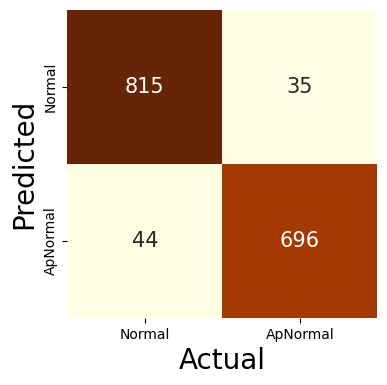

In [17]:
report = classification_report(y_test, y_pred, target_names = ['Normal', 'ApNormal'], digits = 4)
print(report)

Confusion(y_test, y_pred, model_name)